This script is designed to ingest csv data from the NYT covid data on GitHUb, and arrange it for analysis

Currently, this script only works on all states and counties in the mainland USA.

The driving idea here was to graph a rolling two week sum of new cases, the maximum period where someone with CoV19 could be contagious.
From there, that sum is converted to a percentage of the region's population.

First, each region's stats are presented alone, first over the roughly three-year period, then with each year layered on top of each other.

Second, The region's stats are compared, first by raw data, then by percentage.  This is where percentage is most important, because it 
offers comparison between regions with varying population sizes.

I found the results very interesting; while population vary wildly from region to region, averages and sums of active cases follow the same shape as the national average.  The numer of cases from region to region is interesting to compare as well. For instance, Kanawha county, with a population of under 200,000, has the steepest rate of case increase. Alameda County, in the SF Bay area, has a much shallower increase.  

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests
from datetime import datetime
from random import randrange
import os
# import urllib
# from bs4 import BeautifulSoup

In [2]:
#links
US_population_data_20_21 = 'https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv'
NYT__us_csv = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'
NYT_states_csv = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'

# functions

# These two functions pull the data from the nyt GitHub site

def get_filename(link): # pulls file name from url
    split_list = link.split(sep='/')
    return split_list[len(split_list) -1]

def download_from_link(url): # requests and writes file to disk, returns df
    filename = get_filename(url)
    print(filename)
    filepath = f'{os.getcwd()}/covidCSV/{filename}'
    web_request = requests.get(url, allow_redirects=True)
    with open(filepath,'wb') as file:
         file.write(web_request.content)
    file_to_df = pd.read_csv(filepath)
    return file_to_df

def pd_search_tool(df, column,term): # just an attempt to simplify searches
    search = df.index[df[column] == term]
    return search[0]
    # need a way change operator, maybe with if statements

In [3]:
# create folder in current path
!mkdir -p covidCSV
# get census data from csv
census_data = download_from_link(US_population_data_20_21)
pop_data = pd.DataFrame(census_data.loc[0:, census_data.columns[5:10]])

# get files for US and State DFs
USdf = download_from_link(NYT__us_csv)
statedf = download_from_link(NYT_states_csv)

# download all 4 csv files and append to DF
all_counties_df = pd.DataFrame(columns=['date', 'county', 'state', 'fips', 'cases', 'deaths'])
for file_year in range(2020, 2024):
    counties = f'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties-{file_year}.csv'
    all_counties_df = all_counties_df.append(download_from_link(counties),ignore_index=True )

co-est2021-alldata.csv
us.csv
us-states.csv
us-counties-2020.csv
us-counties-2021.csv
us-counties-2022.csv
us-counties-2023.csv


In [30]:
def transform_data(country='USA', state=None,county=None, yearfig=None):

    # poulation = query_pop(country='USA', state='California', county='Orange County', yearfig='EST20')
    population_data = pd.DataFrame(census_data.loc[0:, census_data.columns[5:10]])
    column_list = ['STNAME','ESTIMATESBASE2020','POPESTIMATE2020','POPESTIMATE2021']
        
        #sets index for list "Columns" to be queried
    if yearfig == None:
        x = 2
    elif yearfig == 'BASE20':
        x=1
    elif yearfig == 'EST20':
        x=2
    elif yearfig == 'EST21':
        x=3

    y = x + 1

    if state==None and county==None: 
        population = population_data.loc[population_data['STNAME']==population_data['CTYNAME']].drop_duplicates().sum()[x:y]
        new_df = USdf.copy()
    elif county==None:
        population = population_data.loc[(population_data['STNAME']==population_data['CTYNAME']) & (population_data['STNAME']==f'{state}'), column_list[x:y]]
        new_df = statedf.loc[(statedf['state'] == state)].copy()
    else: 
        population =  population_data.loc[(population_data['STNAME']==f'{state}') & (population_data['CTYNAME']==f'{county} County'), population_data.columns[x:y]]
        new_df = all_counties_df.loc[(all_counties_df['state'] == state)& (all_counties_df['county'] == county)].copy()

    new_df['date'] = pd.to_datetime(new_df['date'])

    daily_diff = new_df['cases'].diff()
    day7avg = daily_diff.rolling(7).sum() / 7
    twoWeekSum = daily_diff.rolling(14).sum()
    sum_2_pop = (twoWeekSum / int(population.iloc[0])) * 100
    total_2_pop = (new_df['cases'] / int(population.iloc[0])) * 100

    dfshape = {'date':new_df['date'],'new_cases':daily_diff,'7_day_average':day7avg,'2_week_sum':twoWeekSum,'2_week_sum_over_population':sum_2_pop, 'case_totals_over_population':total_2_pop}
    # return pd.DataFrame(dfshape)
    newer_df = pd.DataFrame(dfshape)
    return new_df.merge(newer_df, how='left',on='date')





In [91]:
# visualize data
# this should maybe be a class?

# graph data over full 3 year period
def graph_over_time(df, column):

    # separate search data by year
    end_of_20 = pd_search_tool(df, 'date', '2021-01-01')
    end_of_21 = pd_search_tool(df, 'date', '2022-01-01')
    end_of_22 = pd_search_tool(df, 'date', '2023-01-01')
    
    # visualize
    f = plt.figure()
    f.set_figwidth(20)

    # x axis = dates, y axis = selected column
    plt.plot(df.date[0:end_of_20],df[f'{column}'][0:end_of_20], color='blue', label='2020')
    plt.plot(df.date[end_of_20:end_of_21],df[f'{column}'][end_of_20:end_of_21], color='purple', label='2021')
    plt.plot(df.date[end_of_21:end_of_22],df[f'{column}'][end_of_21:end_of_22], color='red', label='2022')
    plt.plot(df.date[end_of_22:],df[f'{column}'][end_of_22:], color='orange', label='2023')
    plt.legend(loc='upper left')
    plt.ylabel(f'{column}')
    plt.title(label=f'{column} over all time')

    plt.show

def graph_year_overlap(df,column):
     
     # separate data by year
    end_of_20 = pd_search_tool(df, 'date', '2021-01-01')
    end_of_21 = pd_search_tool(df, 'date', '2022-01-01')
    end_of_22 = pd_search_tool(df, 'date', '2023-01-01')

    # reset indexes so the year overlay
    df2020 = pd.DataFrame(df[f'{column}'][0:end_of_20]).set_index(pd.Index(range(0, end_of_20)))
    df2021 = pd.DataFrame(df[f'{column}'][end_of_20:end_of_21]).set_index(pd.Index(range(0, (end_of_21 - end_of_20))))
    df2022 = pd.DataFrame(df[f'{column}'][end_of_21:end_of_22]).set_index(pd.Index(range(0, (end_of_22-end_of_21))))
    df2023 = pd.DataFrame(df[f'{column}'][end_of_22:]).set_index(pd.Index(range(0, ((df.count()[0])-end_of_22))))

    # create NaNs for dates prior to first US case in 2020
    dummy_row = pd.Series({0:np.nan},index=[0]) 

    # find num of rows needs to align 2020 data
    # xtra = datetime.strptime(df['date'][0], "%Y-%m-%d") - datetime.strptime('2020-01-01', "%Y-%m-%d")
    xtra = df['date'][0] - datetime.strptime('2020-01-01', "%Y-%m-%d")
    
    # add rows
    for i in range(xtra.days):
        df2020 = pd.concat([dummy_row, df2020]).reset_index(drop = True)

    # visualize
    f = plt.figure()
    f.set_figwidth(20)

    # x axis = days of year, y axis = selcted column
    plt.plot(df2020, color='blue', label='2020')
    plt.plot(df2021, color='purple', label='2021')
    plt.plot(df2022, color='red', label='2022')
    plt.plot(df2023, color='orange', label='2023')
    plt.legend(loc='upper left')
    plt.xticks(np.arange(0,365, 30))
    plt.xlabel('in days (not months)')
    plt.ylabel(f'{column}')
    plt.title(label=f'{column}, all years overlaid')

    plt.show

def regional_comparison(df_list, column):

    # throw error if first var is not list 
    #plot_num = len(df_list)



    f = plt.figure()
    f.set_figwidth(20)
    f.set_facecolor('black')

    plt.style.use('dark_background')
    
    for name, df in enumerate(df_list):
        r = randrange(50,100) * 0.01
        g = randrange(50,100) * 0.01
        b = randrange(50,100) * 0.01

        if 'county' in df.columns:
            graph_label = f'{df["county"][0]} County, {df["state"][0]}'
        elif 'state' not in df.columns:
            graph_label = 'USA'
        else: graph_label = df["state"][0]

        plt.plot(df.date,df[f'{column}'], color=(r,g,b), label=graph_label)

    plt.legend(loc='upper left')
    plt.ylabel(f'{column}')
    plt.title(label=f'{column} over all time')

    plt.show

In [32]:
US = transform_data()

In [33]:
type(US.date[0])

pandas._libs.tslibs.timestamps.Timestamp

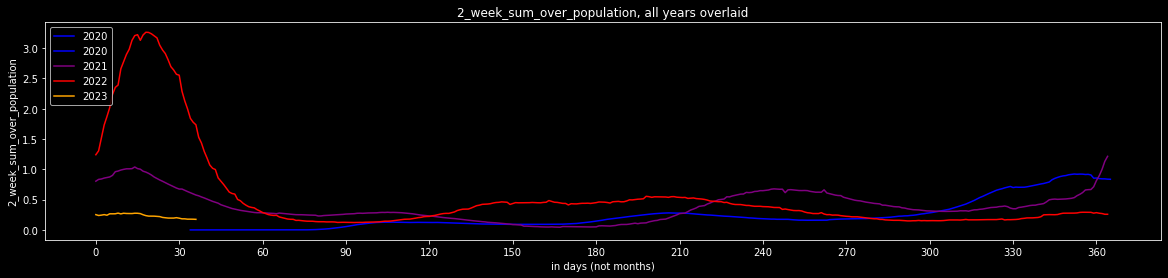

In [119]:
graph_year_overlap(US, '2_week_sum_over_population')

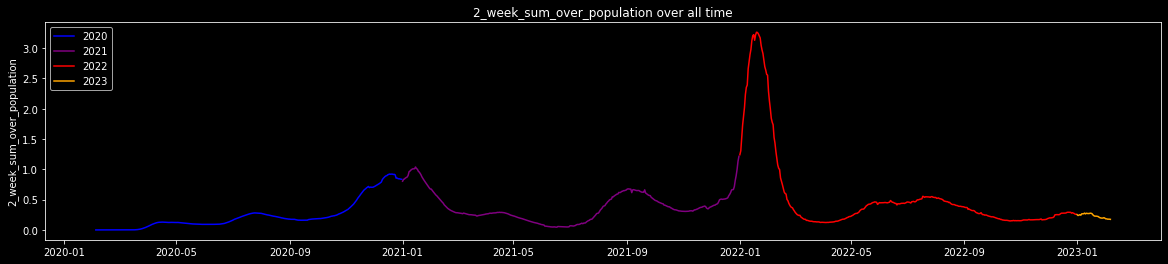

In [120]:
graph_over_time(US, '2_week_sum_over_population')

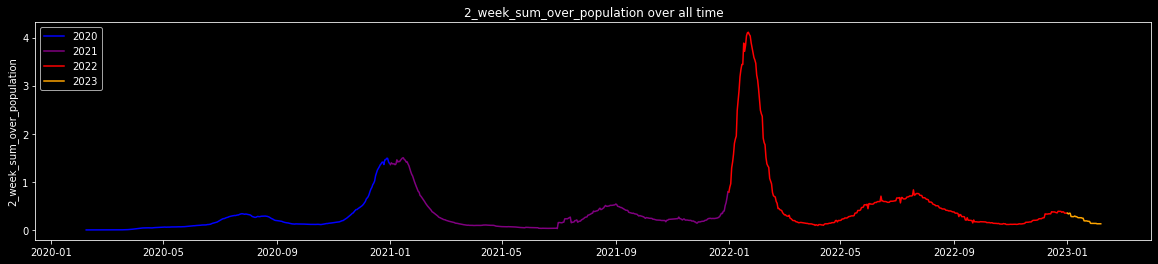

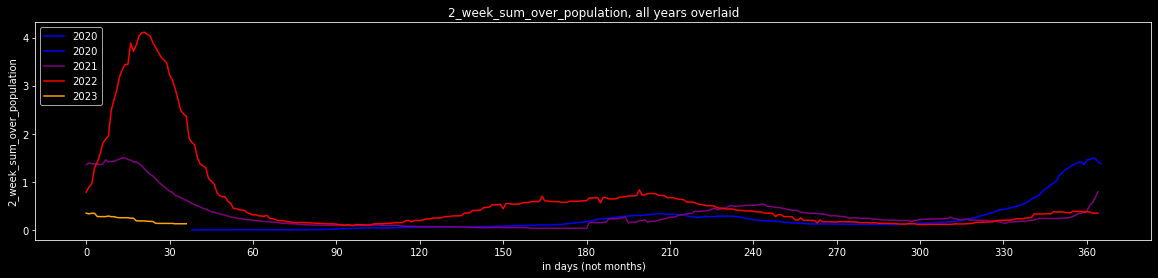

In [36]:
CA = transform_data(country='USA', state='California')
graph_over_time(CA, '2_week_sum_over_population')
graph_year_overlap(CA, '2_week_sum_over_population')

In [37]:
WV = transform_data(country='USA', state='West Virginia')
Kanawha = transform_data(country='USA', state='West Virginia', county= 'Kanawha')
IL = transform_data(country='USA', state='Illinois')
Cook = transform_data(country='USA', state='Illinois', county= 'Cook')


In [38]:
Alameda = transform_data(country='USA', state='California', county= 'Alameda')

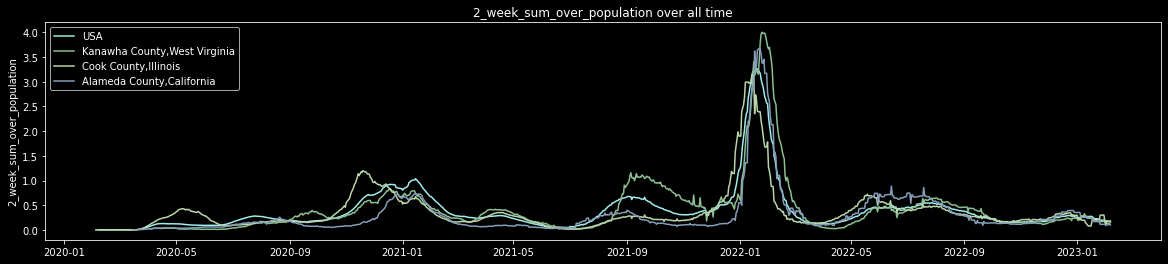

In [39]:
regional_comparison([US,Kanawha,Cook,Alameda], '2_week_sum_over_population')

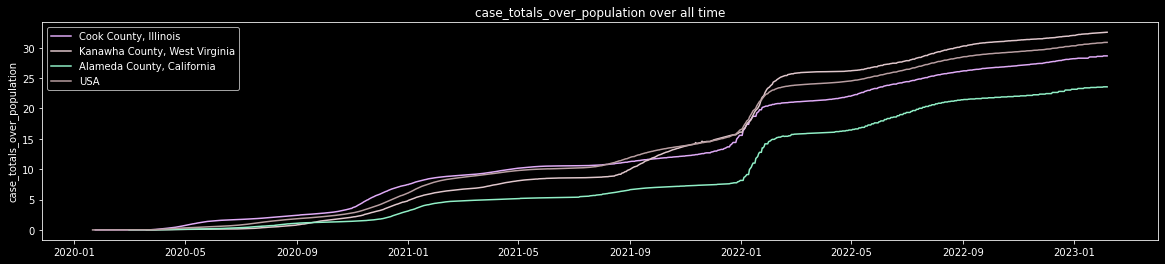

In [118]:
regional_comparison([Cook,Kanawha,Alameda,US], 'case_totals_over_population')

,STNAME,CTYNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021
191,California,California,39538223,39499738,39237836


,date,county,state,fips,cases,deaths
3377009,2023-02-06,Adams,Nebraska,31001.0,7758,92.0
3377010,2023-02-06,Antelope,Nebraska,31003.0,1286,21.0
3377011,2023-02-06,Arthur,Nebraska,31005.0,34,1.0
3377012,2023-02-06,Banner,Nebraska,31007.0,103,2.0
3377013,2023-02-06,Blaine,Nebraska,31009.0,76,4.0
...,...,...,...,...,...,...
3377097,2023-02-06,Washington,Nebraska,31177.0,5442,54.0
3377098,2023-02-06,Wayne,Nebraska,31179.0,2130,18.0
3377099,2023-02-06,Webster,Nebraska,31181.0,843,15.0
3377100,2023-02-06,Wheeler,Nebraska,31183.0,139,2.0


IndexError: single positional indexer is out-of-bounds

,county,state,fips,cases,deaths,date,new_cases,7_day_average,2_week_sum,2_week_sum_over_population,case_totals_over_population


,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0.0
448,2020-03-02,New York City,New York,NaN,1,0.0
482,2020-03-03,New York City,New York,NaN,2,0.0
518,2020-03-04,New York City,New York,NaN,2,0.0
565,2020-03-05,New York City,New York,NaN,4,0.0
...,...,...,...,...,...,...
3364188,2023-02-02,New York City,New York,NaN,3213027,44751.0
3367445,2023-02-03,New York City,New York,NaN,3215219,44765.0
3370702,2023-02-04,New York City,New York,NaN,3215219,44765.0
3373959,2023-02-05,New York City,New York,NaN,3215219,44765.0
